In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
data_file = '/media/liu/KINGSTON/Complex_Urban_LiDAR_Data_Set/urban39-pankyo/sensor_data/encoder.csv'
truth_trajoraty_filePath = '/media/liu/KINGSTON/Complex_Urban_LiDAR_Data_Set/urban39-pankyo/global_pose.csv'

left_diameter = 0.623479
right_diameter = 0.622806
d = 1.52439

fre = 100
low_fre = 10
begin_time = 0  # unit of time is 's'
end_time = 100


In [23]:
# 预先计算各项参数
def tackle_distance(wheel_code, fre):
    print('wait for precalculate...')
    wheel_odemetry = pd.DataFrame()
    wheel_odemetry['time'] = (wheel_code['time'] - wheel_code['time'][0])/10**9
    wheel_odemetry['left_wheel'] = (wheel_code['left_wheel'] - wheel_code['left_wheel'][0])/4096
    wheel_odemetry['right_wheel'] = (wheel_code['right_wheel'] - wheel_code['right_wheel'][0])/4096
    wheel_odemetry['left_ditance'] = wheel_odemetry['left_wheel'] * math.pi * left_diameter
    wheel_odemetry['right_ditance'] = wheel_odemetry['right_wheel'] * math.pi * right_diameter

    wheel_odemetry['left_velocity'] = wheel_odemetry['left_ditance'].diff().fillna(0)*fre
    wheel_odemetry['right_velocity'] = wheel_odemetry['right_ditance'].diff().fillna(0)*fre

    wheel_odemetry['v'] = (wheel_odemetry['left_velocity'] + wheel_odemetry['right_velocity'])/2
    wheel_odemetry['w'] = (wheel_odemetry['left_velocity'] - wheel_odemetry['right_velocity'])/d
    return wheel_odemetry

# 
def compare_diff(wheel_code, lower_wheel_code):
    plt.subplot(2,1,1)
    plt.title('Subplot 1 : wheel_code')
    plt.plot(wheel_code['time'], wheel_code['left_velocity'],color = '#264653', label = 'left_wheel_velocity')
    plt.plot(wheel_code['time'], wheel_code['right_velocity'],color = '#f4a261', label = 'right_wheel_velocity')
    plt.xlabel('time(s)')
    plt.ylabel('velocity(m/s)')
    plt.axis()
    plt.grid()
    plt.legend()
    

    plt.subplot(2,2,3)
    plt.title('Subplot 2 : w')
    plt.plot(wheel_code['time'], wheel_code['w'], color = '#e76f51', label = '100HZ_wheel_code')
    plt.plot(lower_wheel_code['time'], lower_wheel_code['w'], color = '#2a9d8f', label = '10HZ_wheel_code')
    plt.xlabel('time(s)')
    plt.ylabel('w(rad/s)')
    plt.grid()
    plt.legend()

    plt.subplot(2,2,4)
    plt.title('Subplot 3 : velocity')
    plt.plot(wheel_code['time'], wheel_code['v'], color = '#e76f51', label = '100HZ_wheel_code')
    plt.plot(lower_wheel_code['time'], lower_wheel_code['v'], color = '#2a9d8f', label = '10HZ_wheel_code')
    plt.xlabel('time(s)')
    plt.ylabel('v(m/s)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_pos(wheel_code, fre):
    print('start to calculate pos...')
    wheel_code['theta'] = 0
    wheel_code['x'] = 0
    wheel_code['y'] = 0
    for index, row in tqdm(wheel_code.iterrows(), total=len(wheel_code), desc="Processing: situation"):
        v = row['v']
        w = row['w']

        if index > 0:
            pre_row = wheel_code.iloc[index-1]
            pre_theta = pre_row['theta']
            pre_x = pre_row['x']
            pre_y = pre_row['y']

            wheel_code.loc[index, 'theta'] = pre_theta + w / fre 
            wheel_code.loc[index, 'x'] = pre_x + v * math.cos(wheel_code.loc[index, 'theta'])/ fre 
            wheel_code.loc[index, 'y'] = pre_y + v * math.sin(wheel_code.loc[index, 'theta'])/ fre 
            wheel_code.loc[index, 'X'] = -wheel_code.loc[index, 'x'] * math.cos(wheel_code.loc[index, 'theta']) + wheel_code.loc[index, 'y'] * math.sin(wheel_code.loc[index, 'theta'])
            wheel_code.loc[index, 'Y'] = -wheel_code.loc[index, 'x'] * math.sin(wheel_code.loc[index, 'theta']) - wheel_code.loc[index, 'y'] * math.cos(wheel_code.loc[index, 'theta'])

    return wheel_code


def ShowDifferTrajoraty(truth_trajoraty, wheel_code):
    plt.title('truth_trajoraty and wheel_code')
    plt.plot(wheel_code['x'], wheel_code['y'], color = '#f4a261', label = 'wheel_code')
    plt.plot(truth_trajoraty['t2'],truth_trajoraty['t1'], color = '#adb5bd', linestyle = '--', label = 'truth_trajoraty')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

wait for precalculate...
start to calculate pos...


Processing: situation: 100%|██████████| 18668/18668 [00:14<00:00, 1261.22it/s]


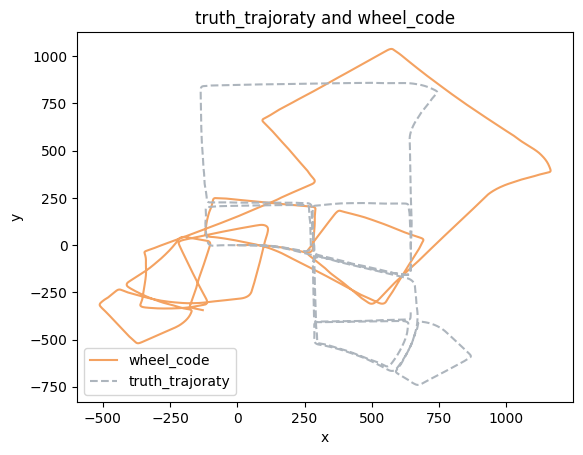

In [24]:
if __name__ =="__main__":

    truth_trajoraty_file = pd.read_csv(truth_trajoraty_filePath, header=None)


    wheel_code = pd.read_csv(data_file, header=None )
    wheel_code.columns = ['time','left_wheel','right_wheel']

    truth_trajoraty_file.columns = ['time','r11','r12','r13','t1','r21','r22','r23','t2','r31','r32','r33','t3']
    truth_trajoraty = truth_trajoraty_file[['time','t1', 't2', 't3']].copy()
    truth_trajoraty['time'] = (truth_trajoraty['time'] - truth_trajoraty['time'][0])/10**9
    truth_trajoraty['t1'] = truth_trajoraty['t1'] - truth_trajoraty['t1'][0]
    truth_trajoraty['t2'] = truth_trajoraty['t2'] - truth_trajoraty['t2'][0]
    truth_trajoraty['t3'] = truth_trajoraty['t3'] - truth_trajoraty['t3'][0]
    # get low

    lower_wheel_code = wheel_code.groupby(wheel_code.index // (fre/low_fre)).head(1)
    lower_wheel_code.reset_index(drop=True, inplace=True)

    # wheel_code = tackle_distance(wheel_code, fre)
    lower_wheel_code = tackle_distance(lower_wheel_code, low_fre)

    # calculate_pos(wheel_code, fre)
    calculate_pos(lower_wheel_code, low_fre)

    # wheel_code = wheel_code[begin_time * fre : end_time * fre]
    # lower_wheel_code = lower_wheel_code[begin_time * low_fre : end_time * low_fre]
    # truth_trajoraty = truth_trajoraty[begin_time * fre : end_time * fre]
    
    # compare_diff(wheel_code, lower_wheel_code)
    
    # ShowDifferTrajoraty(truth_trajoraty, wheel_code)
    ShowDifferTrajoraty(truth_trajoraty, lower_wheel_code)

KeyError: 'left_velocity'

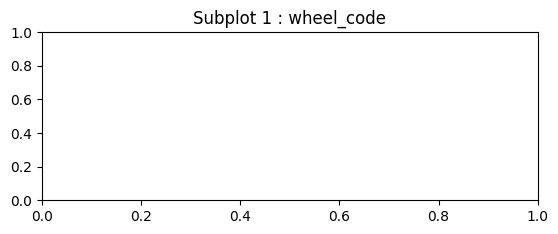

In [25]:
compare_diff(wheel_code, lower_wheel_code)

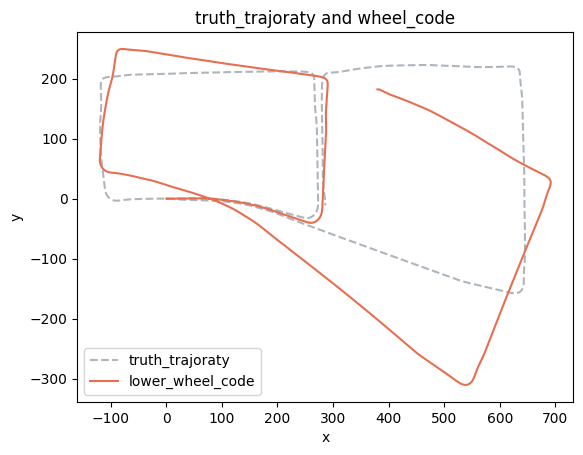

In [26]:
def ShowTrajoraty(wheel_code, lower_wheel_code):
    plt.title('truth_trajoraty and wheel_code')
    plt.plot(wheel_code['x'],wheel_code['y'], color = '#f4a261', label = 'wheel_code')
    plt.plot(lower_wheel_code['x'],lower_wheel_code['y'], color = '#adb5bd', label = 'lower_wheel_code')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
# ShowTrajoraty(wheel_code, lower_wheel_code)


begin = 0
end = 400
cut_wheel_code = wheel_code[begin * fre : end * fre]
cut_lower_wheel_code = lower_wheel_code[begin * low_fre : end * low_fre]
cut_truth_trajoraty = truth_trajoraty[begin * fre : end * fre-700]
# ShowTrajoraty(cut_wheel_code, cut_lower_wheel_code)
# ShowDifferTrajoraty(cut_truth_trajoraty, cut_wheel_code)
# ShowDifferTrajoraty(cut_truth_trajoraty, cut_lower_wheel_code)
plt.title('truth_trajoraty and wheel_code')
plt.plot(cut_truth_trajoraty['t2'],cut_truth_trajoraty['t1'], color = '#adb5bd', linestyle = '--', label = 'truth_trajoraty')
# plt.plot(cut_wheel_code['x'],-cut_wheel_code['y'], color = '#264653', label = 'wheel_code')
plt.plot(cut_lower_wheel_code['x'],cut_lower_wheel_code['y'], color = '#e76f51', label = 'lower_wheel_code')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [28]:
def SaveTrajoraty(wheel_code):
    SaveDF = wheel_code[['time','x', 'y', 'theta','X','Y']]
    SaveDF.to_csv('SaveTrajoraty.csv', index = False)

    return 0


SaveTrajoraty(cut_lower_wheel_code)

0